In [1]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC

import lifelines

In [2]:
# reading dataset from CSV file
cc_df = pd.read_csv("../data/UCI_Credit_Card.csv")

In [3]:
pd.DataFrame(cc_df["default.payment.next.month"].value_counts())
new_df = cc_df.rename(columns={"default.payment.next.month":'default'})



In [4]:
pd.DataFrame(new_df["default"].value_counts())

,default
0,23364
1,6636


In [5]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [23]:
categorical_feats = [
    'PAY_0',
    'PAY_2',
    'PAY_3',
    'PAY_4',
    'PAY_5',
    'PAY_6',
    'MARRIAGE',
    'EDUCATION'
]

numeric_feats = [
    'LIMIT_BAL',
    'BILL_AMT1',
    'BILL_AMT2',
    'BILL_AMT3',
    'BILL_AMT4',
    'BILL_AMT5',
    'BILL_AMT6',
    'PAY_AMT1',
    'PAY_AMT2',
    'PAY_AMT3',
    'PAY_AMT4',
    'PAY_AMT5',
    'PAY_AMT6',
    'AGE',
    'SEX'
]

drop_feats = [
]

passthrough_feats = [

]
target_column = ['default']

In [24]:
preprocessing_final = make_column_transformer(
    (
        FunctionTransformer(lambda x: x == 1),
        target_column,
    ),  # because we need it in this format for lifelines package
    ("passthrough", numeric_feats),
    # (StandardScaler(), numeric_feats),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_feats),
    ("drop", drop_feats),
)


In [25]:
train_df, test_df = train_test_split(new_df, random_state=123)

In [26]:
preprocessing_final.fit(train_df)

ColumnTransformer(transformers=[('functiontransformer',
                                 FunctionTransformer(func=<function <lambda> at 0x00000202A6C56310>),
                                 ['default']),
                                ('passthrough', 'passthrough',
                                 ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2',
                                  'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
                                  'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
                                  'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                                  'PAY_AMT6', 'AGE', 'SEX']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                                  'PAY_6', 'MARRIAGE', 'EDUCATION']),
                                ('drop', 'drop', [

In [27]:
new_columns = (
    target_column
    + passthrough_feats
    + numeric_feats
    + preprocessing_final.named_transformers_["onehotencoder"]
    .get_feature_names(categorical_feats)
    .tolist()
)

In [28]:

train_df_surv = pd.DataFrame(
    preprocessing_final.transform(train_df), index=train_df.index, columns=new_columns
)
test_df_surv = pd.DataFrame(
    preprocessing_final.transform(test_df), index=test_df.index, columns=new_columns
)

In [31]:
train_df_surv.describe()

,default,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6
count,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.00000,22500.000000,2.250000e+04,...,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.00000,22500.000000,22500.000000,22500.000000,22500.000000
mean,0.222622,167912.608000,51055.337244,49041.264133,46961.377200,43389.790578,40363.350933,38763.81320,5673.348800,5.926811e+03,...,0.453911,0.533778,0.010756,0.000489,0.353556,0.46760,0.163378,0.003689,0.009689,0.001600
std,0.416016,130144.258317,73210.223674,71131.003713,68802.264441,64599.545694,61009.524485,59457.26977,16916.734372,2.151420e+04,...,0.497882,0.498869,0.103152,0.022106,0.478084,0.49896,0.369718,0.060625,0.097956,0.039969
min,0.000000,10000.000000,-15308.000000,-67526.000000,-157264.000000,-65167.000000,-61372.000000,-339603.00000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,50000.000000,3613.750000,2916.000000,2680.750000,2293.750000,1727.750000,1200.00000,1000.000000,8.240000e+02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,140000.000000,22339.000000,21052.500000,20089.000000,19067.500000,18043.500000,16855.00000,2100.000000,2.011000e+03,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,240000.000000,66923.500000,63611.750000,60016.250000,54603.000000,50398.500000,49276.25000,5011.000000,5.000000e+03,...,1.000000,1.000000,0.000000,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1000000.000000,964511.000000,983931.000000,855086.000000,891586.000000,927171.000000,961664.00000,873552.000000,1.227082e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [32]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(train_df_surv["AGE" ], train_df_surv["default"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 22500 total observations, 17491 right-censored observations>

Text(0, 0.5, 'Survival probability')

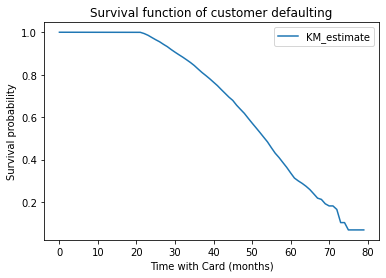

In [33]:
kmf.survival_function_.plot()
plt.title("Survival function of customer defaulting")
plt.xlabel("Time with Card (months)")
plt.ylabel("Survival probability")

In [37]:
old = train_df_surv["AGE"] > 30
young = train_df_surv['AGE'] <= 30
E = train_df_surv["default"]

In [38]:
kmf.fit(event_observed=E[old], label="Old")

TypeError: fit() missing 1 required positional argument: 'durations'